In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_citibike_count = pd.read_csv('CitibikeBridgesAndTSACount/' + 'citibike-daily-counttrips.csv'\
                                , names = ["date", "citibike_count"])
df_citibike_count["date"] = pd.to_datetime(df_citibike_count["date"])

df_citibike_sum = pd.read_csv('CitibikeBridgesAndTSACount/' + 'citibike-daily-sumtriphours.csv'\
                              , names = ["date", "citibike_sum"])
df_citibike_sum["date"] = pd.to_datetime(df_citibike_sum["date"])

df_bridges = pd.read_csv('CitibikeBridgesAndTSACount/' + 'bridges-tunnels-daily-sumtraffic.csv'\
                         , names = ["date", "bridges"])
df_bridges["date"] = pd.to_datetime(df_bridges["date"])

df_tsa = pd.read_csv('CitibikeBridgesAndTSACount/' + 'tsa-daily-travelers.csv'\
                     , names = ["date", "tsa"])
df_tsa["date"] = pd.to_datetime(df_tsa["date"])

df_turnstile = pd.read_csv('SubwayCount/' + 'Turnstile_Usage_Data__2020_trips_per_day.csv'\
                           , names = ["date", "turnstile"])
df_turnstile["date"] = pd.to_datetime(df_turnstile["date"])

df_taxi = pd.read_csv('TaxiCount/' + 'taxi_trips_per_day.csv'\
                      , names = ["date", "taxi"])
df_taxi["date"] = pd.to_datetime(df_taxi["date"])

df_pedestrians = pd.read_csv('pedestrianCount/' + 'pedestrianCountGroupByDate.out', sep = ", "\
                             , names = ["date", "pedestrians"])
df_pedestrians["date"] = pd.to_datetime(df_pedestrians["date"])

df_covid19 = pd.read_csv('CovidData/' + 'COVID_cases_daily.csv')
df_covid19["DATE_OF_INTEREST"] = pd.to_datetime(df_covid19["DATE_OF_INTEREST"])


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [3]:
df_covid19

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,1,0,0
1,2020-03-01,0,0,0
2,2020-03-02,0,0,0
3,2020-03-03,1,1,0
4,2020-03-04,5,2,0
5,2020-03-05,3,8,0
6,2020-03-06,8,5,0
7,2020-03-07,7,6,0
8,2020-03-08,21,15,0
9,2020-03-09,57,30,0


### we first need to outer join all datasets together

In [4]:
total = df_taxi.set_index('date').join(df_pedestrians.set_index('date'), how="outer")
total = total.join(df_turnstile.set_index("date"), how="outer")
total = total.join(df_tsa.set_index("date"), how="outer")
total = total.join(df_bridges.set_index("date"), how="outer")
total = total.join(df_citibike_sum.set_index("date"), how="outer")
total = total.join(df_citibike_count.set_index("date"), how="outer")
total = total.join(df_covid19.set_index("DATE_OF_INTEREST"), how= "outer")

In [5]:
total = total.sort_index()
total

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
2017-10-01,NaN,22525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02,NaN,12597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,NaN,9815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04,NaN,15622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,NaN,17994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-06,NaN,15645.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-07,NaN,18422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-08,NaN,22808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,NaN,12823.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10,NaN,12855.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### we now filter by the region for which we have all parameters

In [6]:
valid = total.loc["2020-03-01" : "2020-06-30"] 
valid

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
2020-03-01,44800.0,6051.0,2183588.0,2280522.0,688870.0,7651.791944,31878.0,0.0,0.0,0.0
2020-03-02,65168.0,8485.0,7378650.0,2089641.0,764768.0,15542.090556,56946.0,0.0,0.0,0.0
2020-03-03,68632.0,5721.0,5457693.0,1736393.0,771447.0,11761.236389,49723.0,1.0,1.0,0.0
2020-03-04,69476.0,8110.0,8085743.0,1877401.0,792404.0,13877.790278,58670.0,5.0,2.0,0.0
2020-03-05,69880.0,6074.0,5480697.0,2130015.0,814060.0,13756.960000,58686.0,3.0,8.0,0.0
2020-03-06,67153.0,6712.0,5412141.0,2198517.0,828554.0,7201.907222,34135.0,8.0,5.0,0.0
2020-03-07,50052.0,7461.0,2597862.0,1844811.0,721020.0,10500.695278,39448.0,7.0,6.0,0.0
2020-03-08,42517.0,8251.0,1856184.0,2119867.0,668474.0,14307.928611,46994.0,21.0,15.0,0.0
2020-03-09,63384.0,3591.0,4782054.0,1909363.0,752304.0,23079.097222,68768.0,57.0,30.0,0.0
2020-03-10,61867.0,7015.0,5036598.0,1617220.0,745492.0,16850.944444,64277.0,69.0,48.0,0.0


### preliminary plots and comparisons - more for the reader to understand the trends than anyhting else

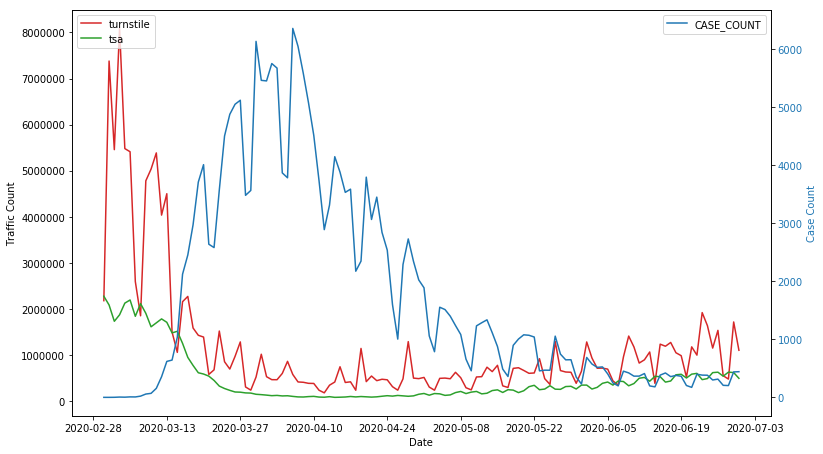

In [7]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid["turnstile"], color=color1)
ax1.plot(valid.index, valid["tsa"], color=color2)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

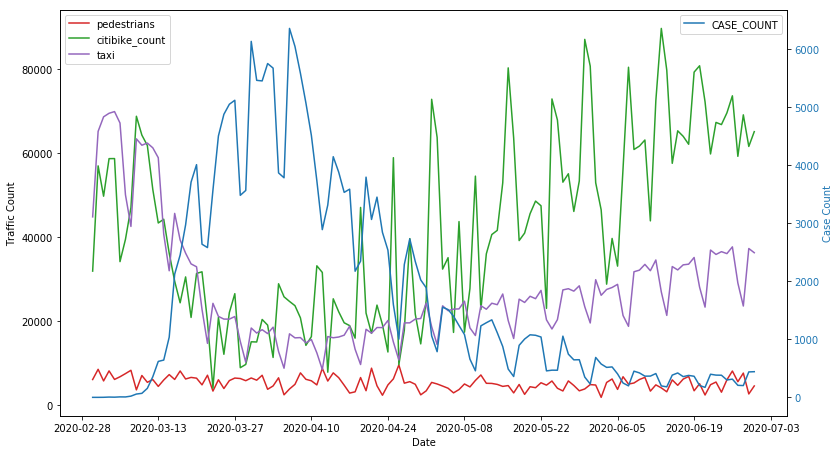

In [8]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:purple'
ax1.set_xlabel('Date')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid["pedestrians"], color=color1)
ax1.plot(valid.index, valid["citibike_count"], color=color2)
ax1.plot(valid.index, valid["taxi"], color=color3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

In [9]:
valid_weekavg = total.loc["2020-02-22" : "2020-06-30"].rolling(window=7).mean()
valid_weekavg = valid_weekavg["2020-03-01":]

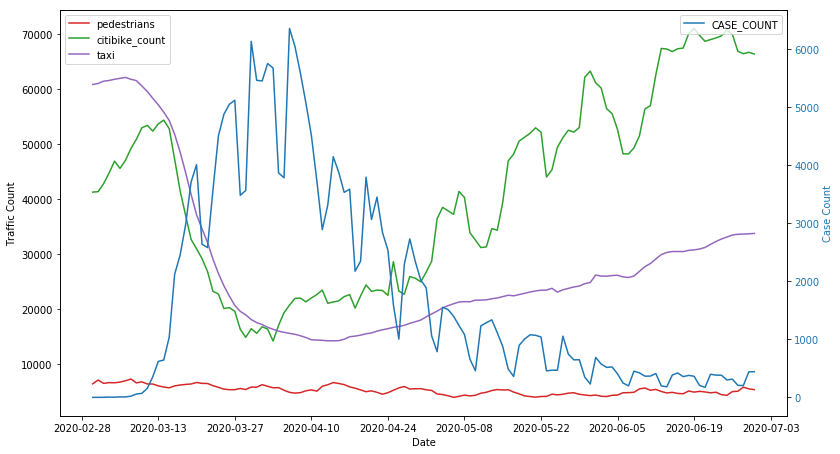

In [10]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:purple'
ax1.set_xlabel('Date')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid_weekavg["pedestrians"], color=color1)
ax1.plot(valid.index, valid_weekavg["citibike_count"], color=color2)
ax1.plot(valid.index, valid_weekavg["taxi"], color=color3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

## now we actually start with the correlation analysis, with the hope of proving the second hypothesis

First, we perform a 4 day moving average and slide covid cases backward 7 days.

This is in accordance with most recent CDC guidelines - incubation period is 7 to 10 days (down from the originally stated 10-14 days)

Our y-value will be the CASE_COUNT

our x-values will be those derived from our Spark jobs and detailed above

In [11]:
x_names = ["taxi", "pedestrians", "turnstile", "tsa", "bridges", "citibike_sum", "citibike_count"]

In [12]:
total = total[x_names + ["CASE_COUNT"] ]
total

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASE_COUNT
2017-10-01,NaN,22525.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02,NaN,12597.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,NaN,9815.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04,NaN,15622.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,NaN,17994.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-06,NaN,15645.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-07,NaN,18422.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-08,NaN,22808.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,NaN,12823.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10,NaN,12855.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
valid = total
valid_avg = valid.rolling(window=4).mean()  # CDC range of 3 days (7 to 10)
y_name = "CASECOUNT_710_days_later"
valid_avg[y_name] = valid["CASE_COUNT"].shift(-7)  # we bring back for incubation period
del valid_avg["CASE_COUNT"]  # we no longer need the cases on the given day
valid_avg = valid_avg.dropna()  # we can only train/test if we have values for all parameters!
valid_avg

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASECOUNT_710_days_later
2020-03-04,62019.00,7091.75,5776418.50,1995989.25,754372.25,12208.227292,49304.25,155.0
2020-03-05,68289.00,7097.50,6600695.75,1958362.50,785669.75,13734.519306,56006.25,355.0
2020-03-06,68785.25,6654.25,6109068.50,1985581.50,801616.25,11649.473472,50303.50,619.0
2020-03-07,64140.25,7089.25,5394110.75,2012686.00,789009.50,11334.338194,47734.75,642.0
2020-03-08,57400.50,7124.50,3836721.00,2073302.50,758027.00,11441.872778,44815.75,1036.0
2020-03-09,55776.50,6503.75,3662060.25,2018139.50,742588.00,13772.407083,47336.25,2121.0
2020-03-10,54455.00,6579.50,3568174.50,1872815.25,721822.50,16184.666389,54871.75,2452.0
2020-03-11,57537.25,6061.50,4265432.00,1837284.00,730359.75,17832.283750,60463.75,2971.0
2020-03-12,62220.50,5510.75,4811084.25,1754431.25,755821.25,17836.229375,61548.25,3707.0
2020-03-13,61096.75,5716.75,4741134.75,1705683.50,755119.75,16466.424931,55192.00,4007.0


ML models dont deal well with very large values, so we use MinMax scaling to bring all values down to range [0, 1] according to their column properties (distribution of values is maintained)



In [14]:
valid_np = np.array(valid_avg)

min_max_scaler = preprocessing.MinMaxScaler()
valid_scaled = min_max_scaler.fit_transform(valid_np)
valid_scaled = pd.DataFrame(valid_scaled,  columns= x_names + [y_name])
valid_scaled

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASECOUNT_710_days_later
0,0.879129,0.988444,0.869346,0.960964,0.917757,0.245453,0.592474,0.005615
1,0.991135,0.990095,1.000000,0.941966,0.972240,0.294401,0.699313,0.037703
2,1.000000,0.862834,0.922074,0.955709,1.000000,0.227534,0.608404,0.080058
3,0.917023,0.987726,0.808748,0.969394,0.978054,0.217427,0.567454,0.083748
4,0.796626,0.997847,0.561890,1.000000,0.924119,0.220876,0.520921,0.146960
5,0.767615,0.819624,0.534205,0.972148,0.897243,0.295616,0.561101,0.321033
6,0.744008,0.841372,0.519324,0.898772,0.861094,0.372978,0.681228,0.374138
7,0.799068,0.692650,0.629844,0.880832,0.875956,0.425817,0.770372,0.457404
8,0.882729,0.534525,0.716334,0.838999,0.920280,0.425943,0.787661,0.575485
9,0.862654,0.593669,0.705246,0.814385,0.919058,0.382014,0.686333,0.623616


Let's first check each parameter's relationship with our target value on its own

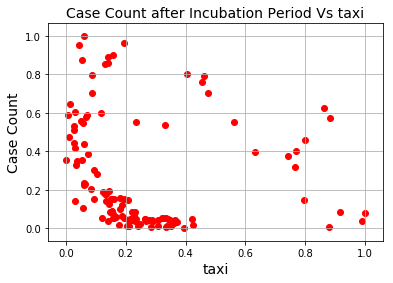

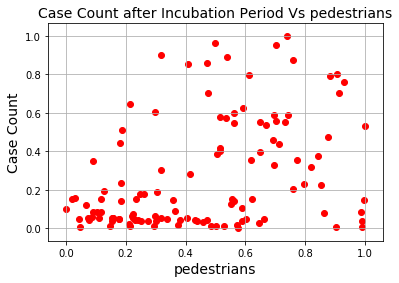

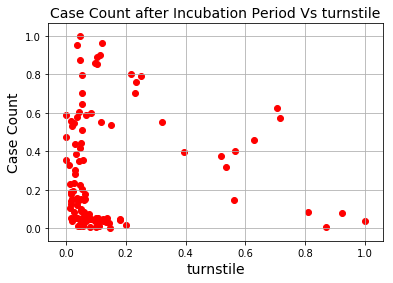

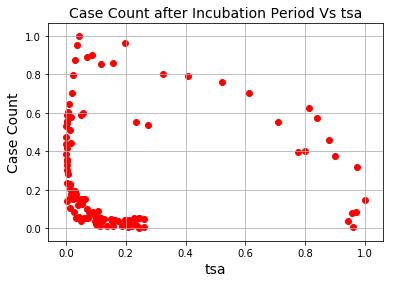

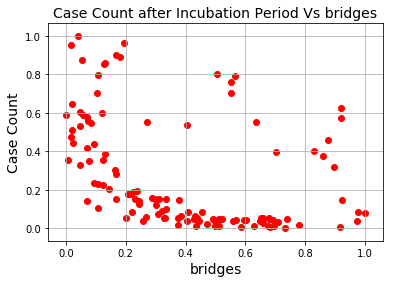

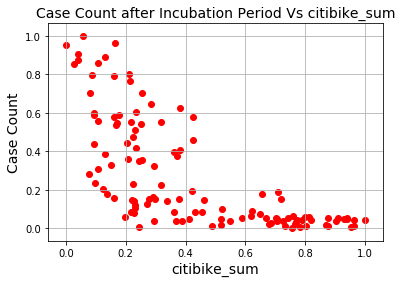

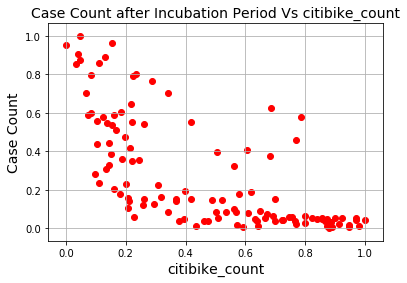

In [15]:

for col in x_names:
    plt.scatter(valid_scaled[col], valid_scaled[y_name], color='red')
    plt.title(f'Case Count after Incubation Period Vs {col}', fontsize=14)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Case Count', fontsize=14)
    plt.grid(True)

    plt.show()

As we can see, each parameter on its own does not provide much information, so we can instead predict with all of them at the same time

### Let's start with a Multi-Linear Regression ! 
We'll progressively get to more copmlex algorithms, as needed

In [16]:
X, Y = valid_scaled[x_names], valid_scaled[y_name]

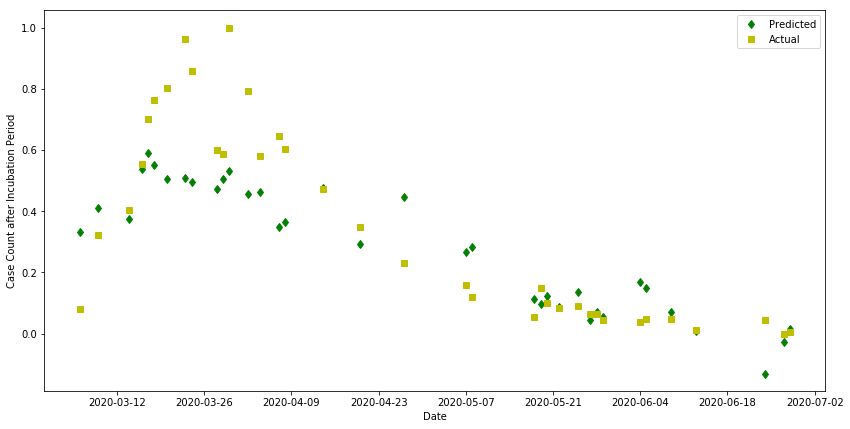

The mean squared error is 0.034193773492824896


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 4)

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# let's see how the predicted and real y_values compare through time!
y_pred = np.array(X_test).dot(model_linear.coef_) + model_linear.intercept_

fig, ax1 = plt.subplots()

color1 = 'tab:green'
color2 = 'tab:purple'
ax1.set_xlabel('Date')
ax1.set_ylabel('Case Count after Incubation Period')
ax1.plot(valid_avg.index[y_test.index], y_pred, 'gd')
ax1.plot(valid_avg.index[y_test.index], y_test, 'ys')

fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(["Predicted", "Actual"])

plt.show()
print(f"The mean squared error is {mean_squared_error(y_test, y_pred)}")

We also want to check that all variables are relevant! - let's get their p-values

In [18]:

x_stats = sm.add_constant(X)
model = sm.OLS(Y, x_stats).fit()
 
print_model = model.summary()
print(print_model)

                               OLS Regression Results                               
Dep. Variable:     CASECOUNT_710_days_later   R-squared:                       0.618
Model:                                  OLS   Adj. R-squared:                  0.594
Method:                       Least Squares   F-statistic:                     25.66
Date:                      Fri, 11 Dec 2020   Prob (F-statistic):           1.45e-20
Time:                              10:18:11   Log-Likelihood:                 39.467
No. Observations:                       119   AIC:                            -62.93
Df Residuals:                           111   BIC:                            -40.70
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

It looks like tsa and citibike_sum information are not statistically relevant for the linear model... we will keep them for now, but may get rid of them if they also appear to be of little significance with other predictors

All in all, we can do better...
### So now, we will look at the Polynomial Regression

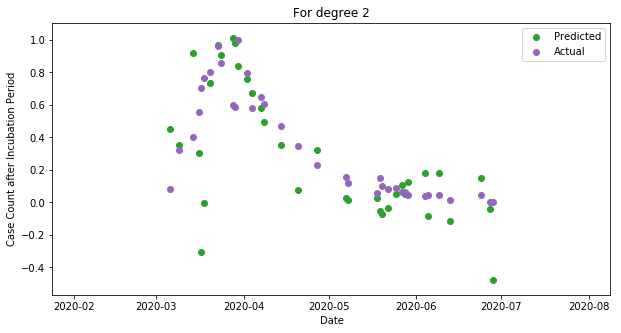

The mean squared error is 0.0831926922269701


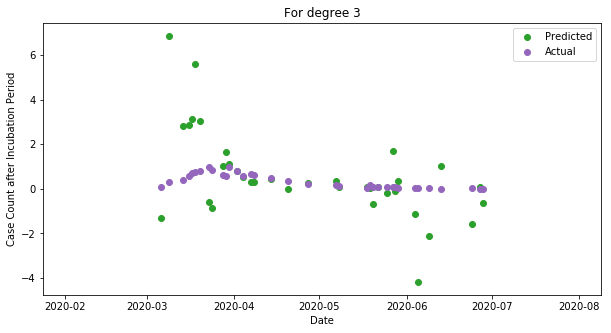

The mean squared error is 3.5940240069287577


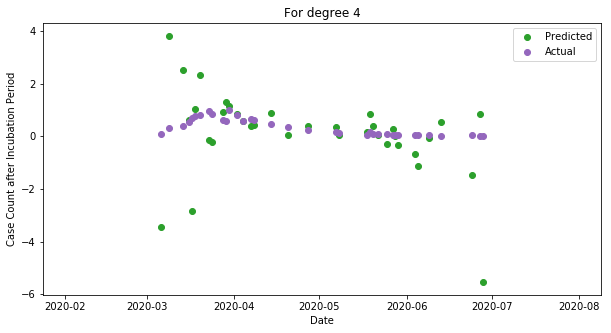

The mean squared error is 2.3347481302313735


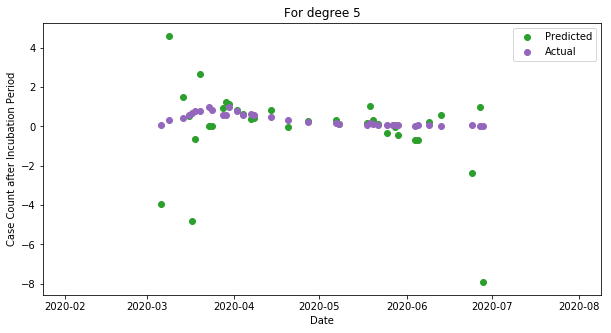

The mean squared error is 4.070542382127156


In [19]:
# we try multiple values for degree!
xy_lst = []

for d in [2, 3, 4, 5]:
    poly = PolynomialFeatures(degree=d)
    poly_X = poly.fit_transform(X)

    poly_Xtrain, poly_Xtest, poly_ytrain, poly_ytest = train_test_split(poly_X, Y, test_size = 0.3, random_state = 4)

    model_linear = LinearRegression()
    model = model_linear.fit(poly_Xtrain, poly_ytrain)
    y_pred = model.predict(poly_Xtest)
    #score = model.score(poly_Xtest, poly_ytest)
    
    fig, ax1 = plt.subplots()

    color1 = 'tab:green'
    color2 = 'tab:purple'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'Case Count after Incubation Period')
    ax1.set_title(f"For degree {d}")
    ax1.scatter(valid_avg.index[poly_ytest.index], y_pred, color=color1)
    ax1.scatter(valid_avg.index[poly_ytest.index], poly_ytest, color=color2)

    fig.set_figheight(5)
    fig.set_figwidth(10)
    ax1.legend(["Predicted", "Actual"])

    plt.show()
    
    print(f"The mean squared error is {mean_squared_error(poly_ytest, y_pred)}")

degree=2 returns the smallest mean squared error, but it is still bigger than with Linear Regression!

### Let's try GradientBoosting and Random Forest Regressors

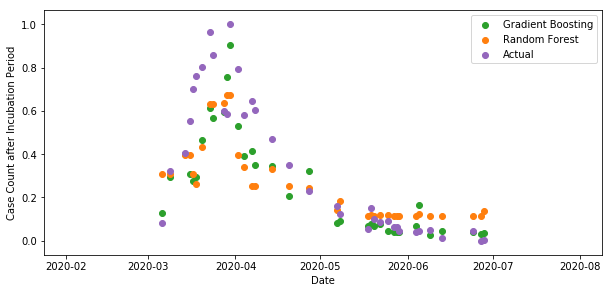

The mean squared error is 0.03124153360008896 for Random Forest
The mean squared error is 0.04184058392382553 for Gradient Boosting


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 4)

# Training classifiers
gb_reg = GradientBoostingRegressor(random_state=1, n_estimators=10)
rf_reg = RandomForestRegressor(random_state=1, n_estimators=10)

rf_reg = rf_reg.fit(X_train, y_train)
gb_reg = gb_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
y_pred_gb = gb_reg.predict(X_test)

fig, ax1 = plt.subplots()

color1 = 'tab:green'
color2 = 'tab:purple'
color2 = 'tab:orange'

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Case Count after Incubation Period')
ax1.scatter(valid_avg.index[poly_ytest.index], y_pred_rf, color=color1)
ax1.scatter(valid_avg.index[poly_ytest.index], y_pred_gb, color=color2)
ax1.scatter(valid_avg.index[poly_ytest.index], y_test, color=color3)

fig.set_figheight(4.5)
fig.set_figwidth(10)
ax1.legend(["Gradient Boosting", "Random Forest", "Actual"])

plt.show()

print(f"The mean squared error is {mean_squared_error(y_test, y_pred_rf)} for Random Forest")
print(f"The mean squared error is {mean_squared_error(y_test, y_pred_gb)} for Gradient Boosting")

Random Forest does perform better than Linear, but Gradient Boosting slightly worse (on MSE terms)
### Let's now join all three (Polynomial is much worse,  so we omit it) through a Voting Ensemble Regressor, that will return the average precision! 

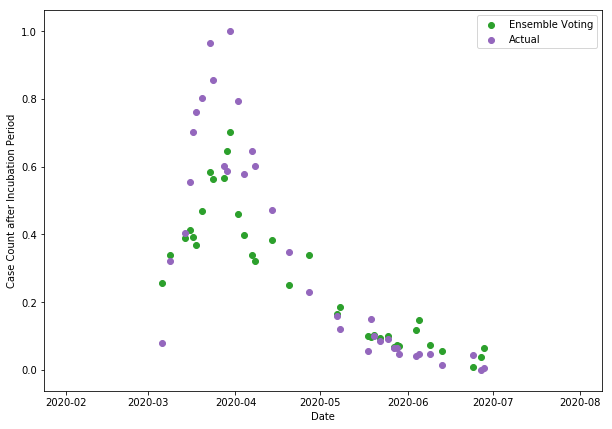

The mean squared error is 0.03109706703284238 for the Ensemble Voting


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 4)

gb_reg = GradientBoostingRegressor(random_state=1, n_estimators=10)
rf_reg = RandomForestRegressor(random_state=1, n_estimators=10)
lin_reg = LinearRegression()
voting_reg = VotingRegressor(estimators=[('gb', gb_reg), ('rf', rf_reg), ('lr', lin_reg)])

voting_reg = voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)

fig, ax1 = plt.subplots()

color1 = 'tab:green'
color2 = 'tab:purple'

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Case Count after Incubation Period')
ax1.scatter(valid_avg.index[poly_ytest.index], y_pred, color=color1)
ax1.scatter(valid_avg.index[poly_ytest.index], y_test, color=color2)

fig.set_figheight(7)
fig.set_figwidth(10)
ax1.legend(["Ensemble Voting", "Actual"])

plt.show()

print(f"The mean squared error is {mean_squared_error(y_test, y_pred)} for the Ensemble Voting")


## We have managed to bring MSE down all the way to 0.0312 ! 

The graph below shows how accurately the Voting Regressor predicts future case counts

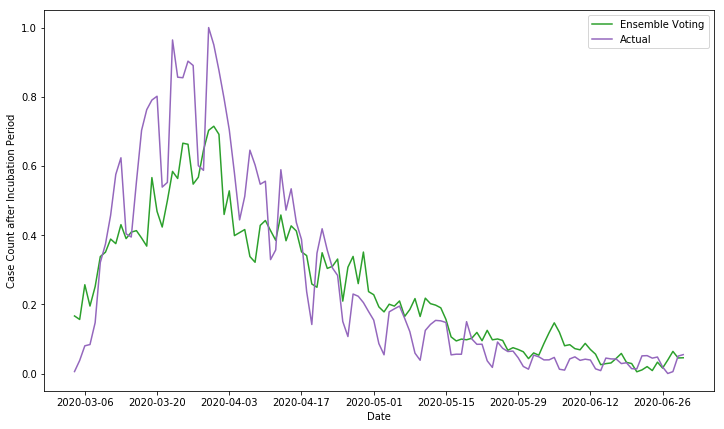

In [22]:
all_predicted = voting_reg.predict(X)

fig, ax1 = plt.subplots()

color1 = 'tab:green'
color2 = 'tab:purple'

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Case Count after Incubation Period')
ax1.plot(valid_avg.index, all_predicted, color=color1)
ax1.plot(valid_avg.index, Y, color=color2)

fig.set_figheight(7)
fig.set_figwidth(12)
ax1.legend(["Ensemble Voting", "Actual"])

plt.show()

For such a small data set, very impressive results!

Its a pity more datasets havent been updated since eo june; it would be great to try and predict the last couple of months of data

### We now need to rescale msq_error back to its absolute value range

In [23]:
valid_np = np.array(valid_avg[y_name]).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()
valid_scaled = min_max_scaler.fit_transform(valid_np)

In [24]:
# find out what the MSE score means on absolute count case values
min_max_scaler.inverse_transform(np.array(mean_squared_error(y_test, y_pred)).reshape(-1, 1))

array([[313.82801882]])

### this means that the mean squared error on case counts would be of +_ 315 cases per day! At the current case of over 10,000 new cases each day in NYC as of the day of writing, it is very small! If new data comes from the datasets used and the model maintains its robustness, this model could provide health services teams a much more precise view of how many cases will be comming soon and so better allocate resources and medical supplies!